In [1]:
import sys
sys.path.insert(0, '../../../network')
sys.path.insert(0, '../../../figures')
from sequences import GaussianSequence
from transfer_functions import ErrorFunction
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('dark') 
# plt.rcParams["font.family"] = "arial"
colors = sns.color_palette('deep')

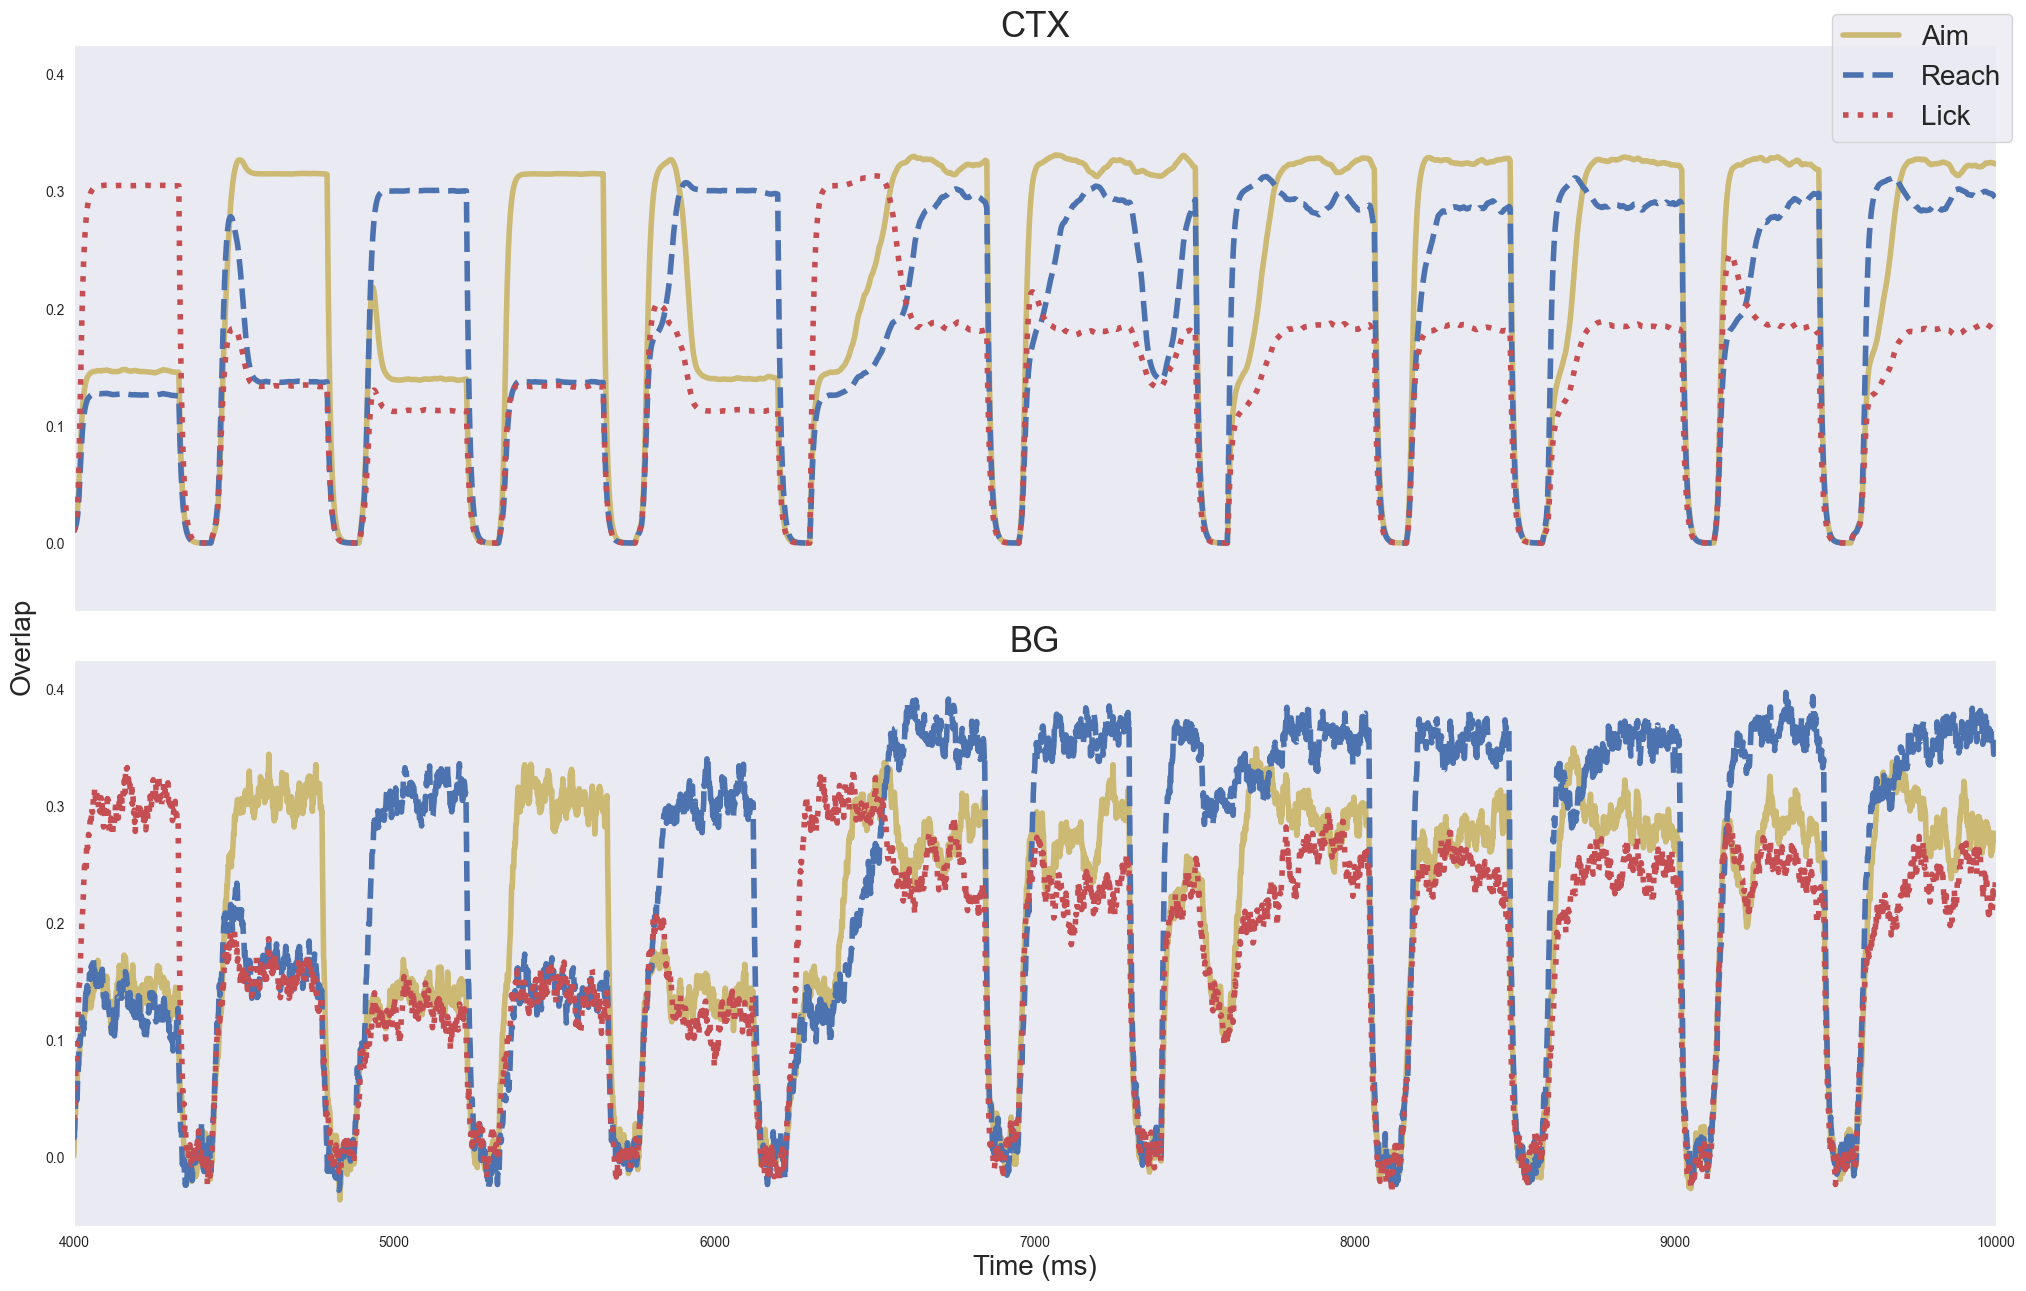

In [6]:
filename = './output/test.npz'
data = np.load(filename) 
overlaps_ctx = data['overlaps_ctx']
overlaps_bg = data['overlaps_bg']

fig, axes = plt.subplots(2,1, sharex=True, sharey=True, tight_layout=True, figsize=(20,13))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=4, color=colors[8])
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
axes[1].plot(overlaps_bg[0], linestyle='solid', linewidth=4, color=colors[8])
axes[1].plot(overlaps_bg[1], linestyle='dashed', linewidth=4, color=colors[0])
axes[1].plot(overlaps_bg[2], linestyle='dotted', linewidth=4, color=colors[3])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("BG", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(4000, 10000))
plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.show()
